In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from torch import nn
import pyro
from pyro import distributions as dist


In [2]:
def simulate(E=2, N=50, S=0.1):
    W = np.random.normal(0.0, 1.0, [E, 1])
    X1 = np.arange(1, N+1, 1)/100
    X1 = (X1 - np.mean(X1))/np.std(X1)
    X2 = np.random.uniform(-5, 5, N)
    Y = 3+np.reshape(-np.abs(np.log( X1+np.abs(np.min(X1))+0.1 ) )*0.45+ X2*np.sin(X2)*0.1 + np.random.normal(0.0, (np.cos(X2)+1.8)*S, N), [-1,1])
    X2 = (X2 - np.mean(X2))/np.std(X2)
    X = np.concatenate(( np.reshape(X1, [-1,1]), np.reshape(X2, [-1,1]) ),1)
    #Y = np.matmul(X, W) + np.random.normal(0.0, S, [N, 1])
    #Y = (Y - np.mean(Y))#/np.std(Y)
    return X, Y, W

def bounds_and_coverage(preds, true):
    mean_preds = np.mean(preds, 1).reshape([-1, 1])#-true
    mean_stddev = np.std(preds, 1).reshape([-1, 1])#-true
    upper = (mean_preds + (1.96 * mean_stddev)).tolist()
    lower = (mean_preds - (1.96 * mean_stddev)).tolist()
    bounds = np.concatenate((np.asarray(upper), np.asarray(lower)), 1)
    coverage = np.mean(( true < bounds[:,[0]] )&( true > bounds[:,[1]] ))
    return mean_preds, bounds, coverage

def plot_uncertainties(preds, true, X):
    mean_preds, bounds, coverage = bounds_and_coverage(preds, true)
    plt.scatter(X, true, color="red", label="y")
    plt.scatter(X, mean_preds, color="blue", label="pred")
    plt.scatter(X, bounds[:,[0]], alpha=0.7,
        color="orange", label="upper")
    plt.scatter(X, bounds[:,[1]], alpha=0.7,
        color="orange", label="lower")
    plt.legend(loc="upper left")
    plt.text(1, -1.5, f'Coverage: {np.round(coverage, 3)}')
    return np.concatenate((mean_preds, bounds), 1), coverage

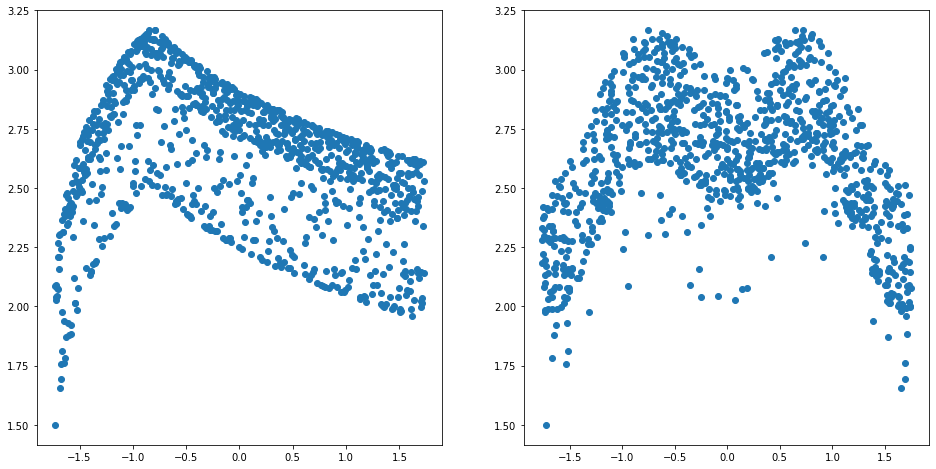

In [3]:
np.random.seed(8)
X, Y, W = simulate(N = 1000, S = 0.001)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], Y)
plt.subplot(1, 2, 2)
plt.scatter(X[:,1], Y)

In [4]:
np.random.seed(8)
X, Y, W = simulate(N = 1000, S = 0.001)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], Y)
plt.subplot(1, 2, 2)
plt.scatter(X[:,1], Y)
data = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(data, batch_size=20, shuffle=True)

In [5]:


net = nn.Sequential(nn.Linear(2, 10), 
                    #nn.Tanh(), 
                    #nn.Linear(100, 50),
                    nn.Tanh(),
                    nn.Linear(10, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
likelihood = tyxe.likelihoods.HomoskedasticGaussian(X.shape[0],scale=0.1)
inference = tyxe.guides.AutoNormal
bnn = tyxe.VariationalBNN(net, prior, likelihood, inference)

In [6]:

optim = pyro.optim.Adam({"lr": 1e-3})
with tyxe.poutine.local_reparameterization():
    bnn.fit(dataloader, optim, 150)

In [7]:
#predictions = bnn.predict([torch.tensor(X, dtype=torch.float32)], num_predictions=  100)
Preds = torch.cat([bnn(torch.tensor(X, dtype=torch.float32)) for _ in range(100)], 1).data.cpu().numpy()


<Figure size 432x288 with 0 Axes>

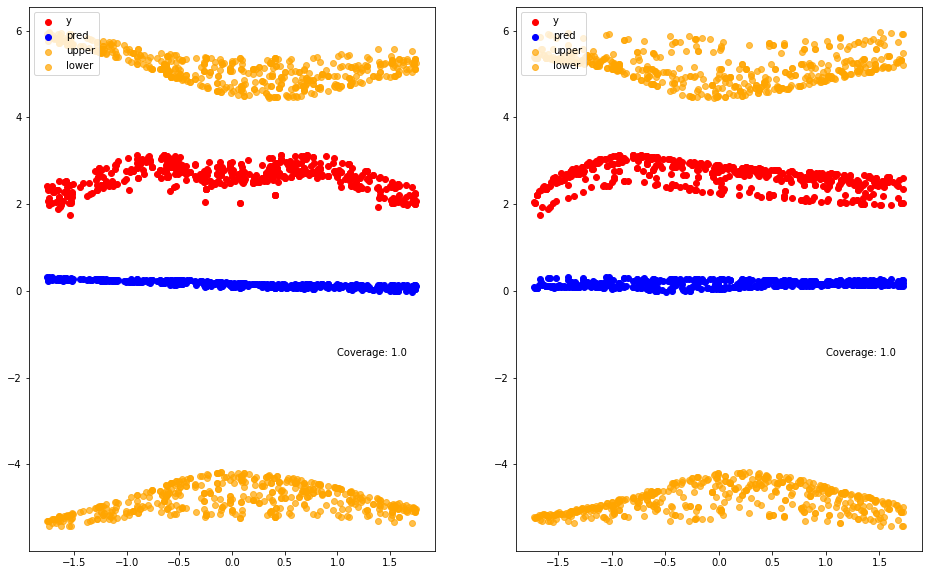

In [8]:
thin = np.random.randint(0, X.shape[0], size = 500)

fig = plt.figure()
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
#plt.ylim(-4, 4)
_ = plot_uncertainties(Preds[thin,:], Y[thin], X[:,1][thin])
plt.subplot(1, 2, 2)
#plt.ylim(-4, 4)
_ = plot_uncertainties(Preds[thin,:], Y[thin], X[:,0][thin])

In [51]:
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
pyro.clear_param_store()


def model(X, Y):
    N, D_X = X.shape
    
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(D_X, 50), torch.ones(D_X, 50)))
    z1 = torch.nn.functional.relu(torch.matmul(X, w1))

    w2 = pyro.sample("w2", dist.Normal(torch.zeros(50, 50), torch.ones(50, 50)))
    z2 = torch.nn.functional.relu(torch.matmul(z1, w2))
    
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(50, 1), torch.ones(50, 1)))
    z3 = torch.matmul(z2, w3)
    
    prec_obs = pyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    
    with pyro.plate("data", N):
        pyro.sample("obs", dist.Normal(z3, prec_obs).to_event(1), obs=Y)
        
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
guide = pyro.infer.autoguide.guides.AutoDiagonalNormal(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


for step in range(100):
    for x, y in dataloader:
        loss = svi.step(x, y)
        if step % 1 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))


[iter 0]  loss: 5011.8846
[iter 0]  loss: 4969.6670
[iter 0]  loss: 4967.6039
[iter 0]  loss: 4941.9978
[iter 0]  loss: 4918.0741
[iter 0]  loss: 4947.8289
[iter 0]  loss: 4959.6458
[iter 0]  loss: 4985.3972
[iter 0]  loss: 4927.3703
[iter 0]  loss: 5007.7455
[iter 0]  loss: 4956.9867
[iter 0]  loss: 4934.7522
[iter 0]  loss: 4922.5315
[iter 0]  loss: 4913.0713
[iter 0]  loss: 4914.5267
[iter 0]  loss: 4950.3009
[iter 0]  loss: 4978.9490
[iter 0]  loss: 4965.6274
[iter 0]  loss: 4873.9509
[iter 0]  loss: 4919.4003
[iter 0]  loss: 4892.0904
[iter 0]  loss: 4852.8788
[iter 0]  loss: 4854.9396
[iter 0]  loss: 4864.8575
[iter 0]  loss: 4913.1160
[iter 0]  loss: 4885.7382
[iter 0]  loss: 4916.1731
[iter 0]  loss: 4893.3727
[iter 0]  loss: 4920.0596
[iter 0]  loss: 4884.0728
[iter 0]  loss: 4897.7897
[iter 0]  loss: 4876.7826
[iter 0]  loss: 4779.8669
[iter 0]  loss: 4932.1172
[iter 0]  loss: 4829.1322
[iter 0]  loss: 4851.0014
[iter 0]  loss: 4813.2869
[iter 0]  loss: 4891.4404
[iter 0]  lo

In [53]:
posterior_samples = pyro.infer.Predictive(model, guide=guide, num_samples=100,return_sites=("obs", "_RETURN"))#(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))

In [57]:
posterior_samples(data['data'].float())

IndexError: too many indices for tensor of dimension 2

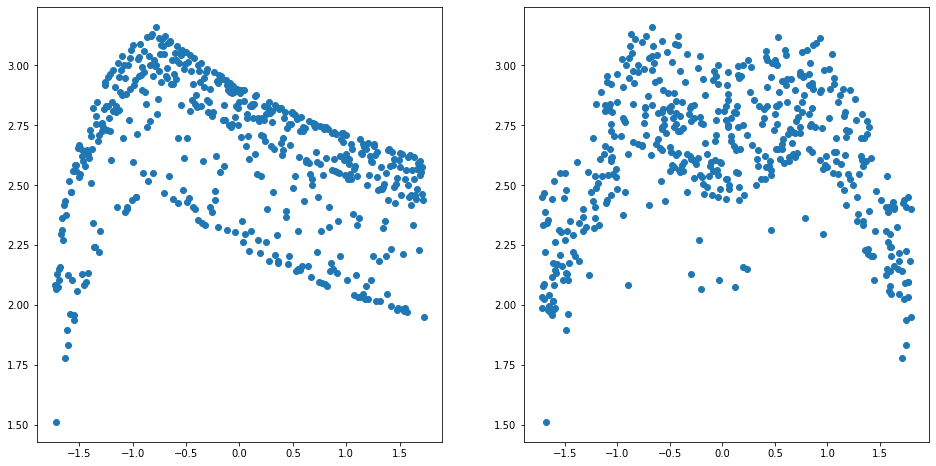

In [176]:
import os
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from torch.distributions import constraints
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.nn.module import to_pyro_module_
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import Adam
from pyro.infer.autoguide import guides

np.random.seed(8)
X, Y, W = simulate(N = 500, S = 0.001)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], Y)
plt.subplot(1, 2, 2)
plt.scatter(X[:,1], Y)
data = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(data, batch_size=200, shuffle=True)

d = 50
neural_network = nn.Sequential(
     nn.Linear(2, d),
     nn.ReLU(),
     nn.Linear(d, d),
     nn.ReLU(),
     nn.Linear(d, 1),
 )
 
to_pyro_module_(neural_network)
 
for m in neural_network.modules():
     for name, value in list(m.named_parameters(recurse=False)):
         setattr(m, name, PyroSample(prior=dist.Normal(0, 1)
                                       .expand(value.shape)
                                       .to_event(value.dim())))
         
class BayesianNeuralNetwork(PyroModule):
     def __init__(self, neural_network):
         super().__init__()
         self.neural_network= neural_network
 
     def forward(self, x, y=None):
         sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
         mean = self.neural_network(x).squeeze(-1)
         with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
            return obs
     
model = BayesianNeuralNetwork(neural_network)
 
guide= guides.AutoDiagonalNormal(model, init_scale=1.)
 
optimizer = Adam({"lr": 0.03}) 
 
svi= SVI(model, guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()


In [107]:
for step in range(100):
    for x, y in dataloader:
        loss = svi.step(x, y)
        if step % 1 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

[iter 0]  loss: 205487.7083
[iter 0]  loss: 96977.5785
[iter 0]  loss: 109502.1302
[iter 0]  loss: 109187.6717
[iter 0]  loss: 95898.0325
[iter 0]  loss: 136283.1434
[iter 0]  loss: 109188.6587
[iter 0]  loss: 105571.4349
[iter 0]  loss: 114725.8011
[iter 0]  loss: 593178.0603
[iter 0]  loss: 111994.4797
[iter 0]  loss: 115434.5889
[iter 0]  loss: 100686.9792
[iter 0]  loss: 110905.0949
[iter 0]  loss: 98230.4797
[iter 0]  loss: 116898.9100
[iter 0]  loss: 97672.3329
[iter 0]  loss: 93437.4401
[iter 0]  loss: 96106.2573
[iter 0]  loss: 109204.7945
[iter 0]  loss: 103314.4757
[iter 0]  loss: 93021.9386
[iter 0]  loss: 111873.9122
[iter 0]  loss: 109773.4285
[iter 0]  loss: 107959.0716
[iter 1]  loss: 104513.3351
[iter 1]  loss: 104774.0197
[iter 1]  loss: 106553.2292
[iter 1]  loss: 99083.4506
[iter 1]  loss: 88287.8743
[iter 1]  loss: 65098.2721
[iter 1]  loss: 91189.4216
[iter 1]  loss: 104016.8352
[iter 1]  loss: 225800.4941
[iter 1]  loss: 102562.4043
[iter 1]  loss: 94552.0919
[ite

In [116]:
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100,return_sites=("obs", "_RETURN"))
samples = predictive(torch.tensor(X, dtype=torch.float32))
Preds = samples["obs"].t().data.cpu().numpy()


<Figure size 432x288 with 0 Axes>

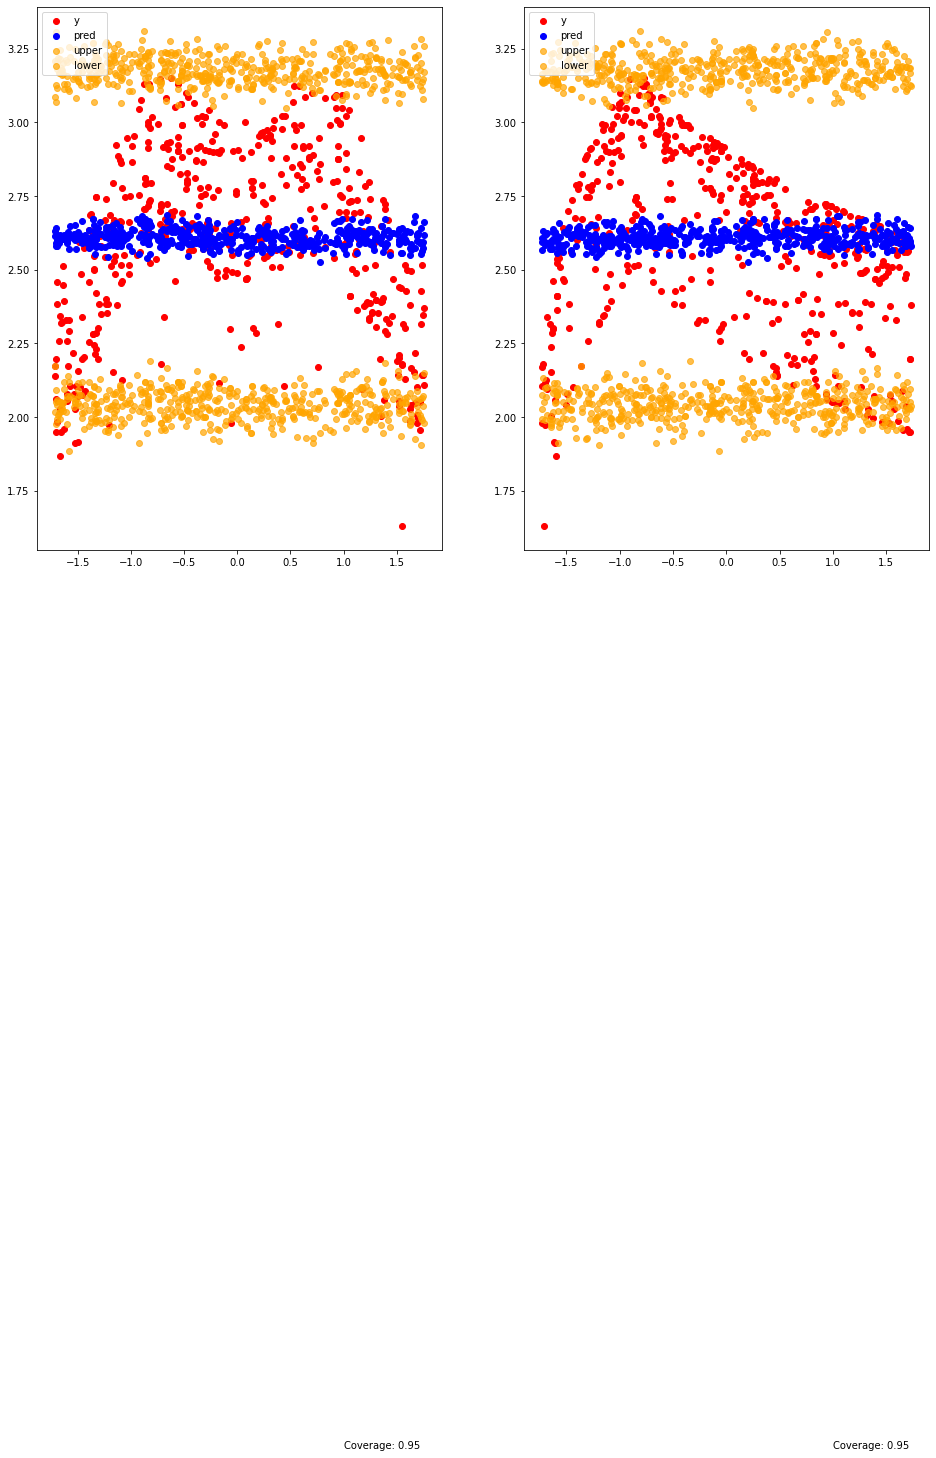

In [109]:
thin = np.random.randint(0, X.shape[0], size = 500)

fig = plt.figure()
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
#plt.ylim(-4, 4)
_ = plot_uncertainties(Preds[thin,:], Y[thin], X[:,1][thin])
plt.subplot(1, 2, 2)
#plt.ylim(-4, 4)
_ = plot_uncertainties(Preds[thin,:], Y[thin], X[:,0][thin])

In [199]:
pyro.clear_param_store()
nuts_kernel = pyro.infer.NUTS(model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=200)

In [200]:
mcmc.run(torch.tensor(X, dtype=torch.float32), torch.tensor(Y,dtype=torch.float32))

Sample:  52%|█████▎    | 210/400 [3:37:46, 427.94s/it, step size=4.02e-04, acc. prob=0.961]

In [179]:
predictive = pyro.infer.Predictive(model, samples)(torch.tensor(X, dtype=torch.float32), None)

In [180]:
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

sigma: (100, 1)
neural_network.0.weight: (100, 1, 50, 2)
neural_network.0.bias: (100, 1, 50)
neural_network.2.weight: (100, 1, 50, 50)
neural_network.2.bias: (100, 1, 50)
neural_network.4.weight: (100, 1, 1, 50)
neural_network.4.bias: (100, 1, 1)


<Figure size 432x288 with 0 Axes>

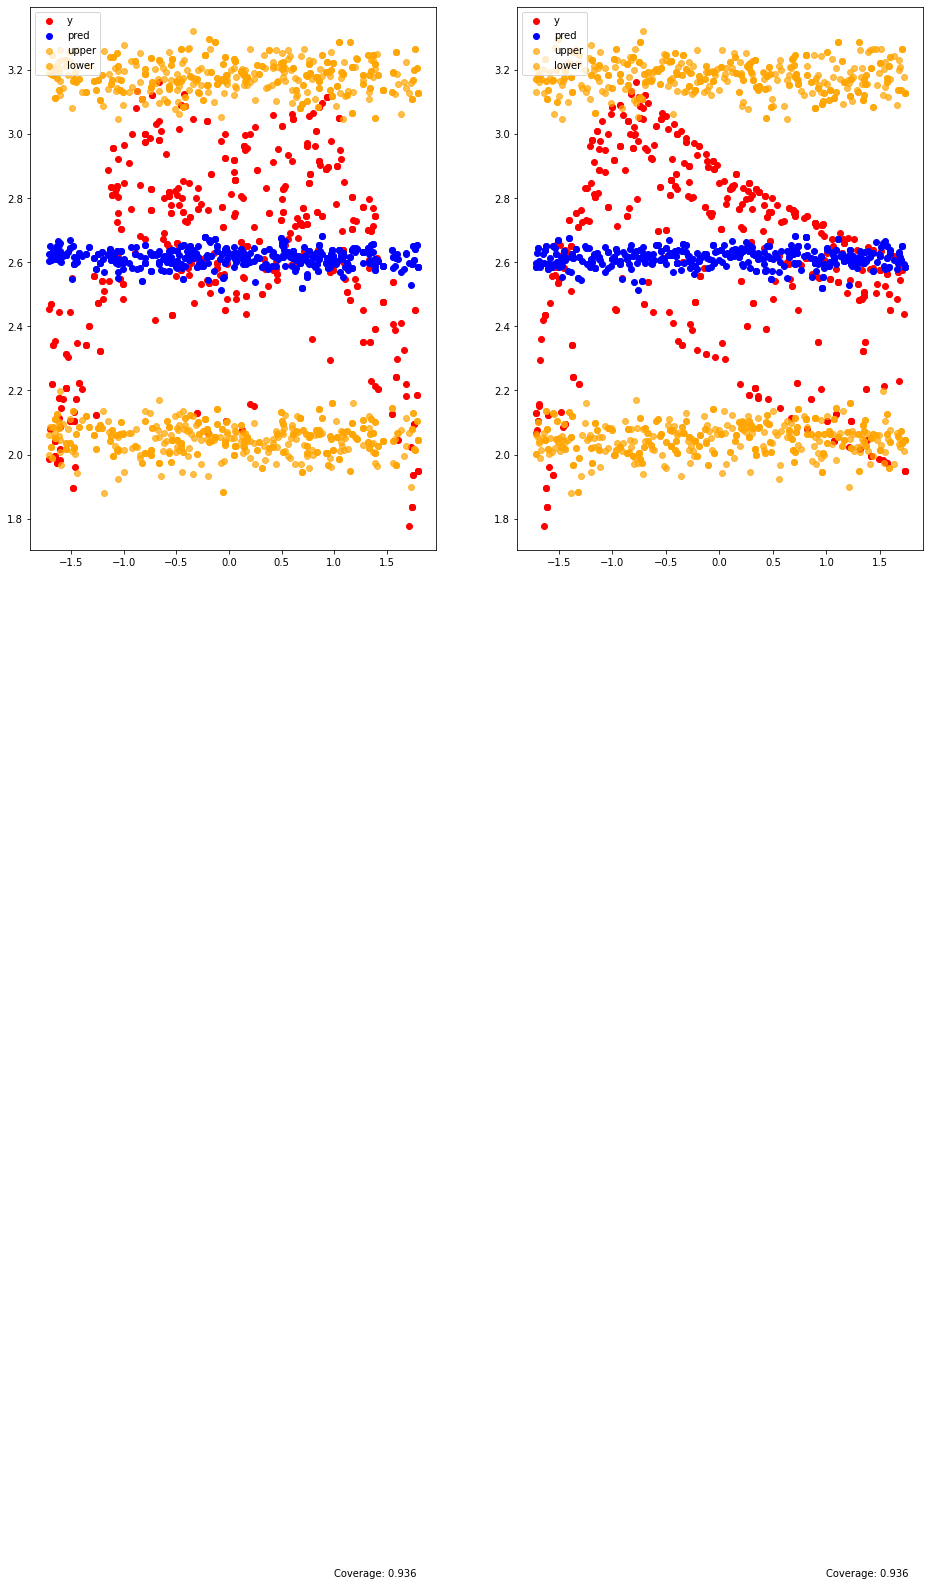

In [196]:
torch.cat( [model(torch.tensor(X, dtype=torch.float32)).reshape([-1,1]) for _ in range(100)], 1  ).data.cpu().numpy()

thin = np.random.randint(0, X.shape[0], size = 500)

fig = plt.figure()
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
#plt.ylim(-4, 4)
_ = plot_uncertainties(Preds[thin,:], Y[thin], X[:,1][thin])
plt.subplot(1, 2, 2)
#plt.ylim(-4, 4)
_ = plot_uncertainties(Preds[thin,:], Y[thin], X[:,0][thin])
